# **Fashion Recommendation System Using Image features**

A Fashion Recommendation System utilizing Image Features leverages computer vision and machine learning to assess the visual characteristics of fashion items, such as color, texture, and style, to suggest similar or complementary products. The process starts with compiling a diverse dataset of fashion items, ensuring uniformity in image format and resolution. These images are then preprocessed for feature extraction. A pre-trained CNN model, like VGG16, ResNet, or InceptionV3, is employed to extract features from the images. The system compares feature vectors, ranks the images according to their similarity to a given input, and recommends the most similar items.


## **Dataset**

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# function to load and display an image
def display_image(file_path):
    image = Image.open(file_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()



Now, we will create a list of all image file paths that will be used later in extracting the features from every image in the dataset, we will be using the fashion-product-images-dataset from Kaggle :

In [6]:
import glob
import os

# Directory path containing your images
image_directory = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/'

# Collect image file paths
image_paths_list = [
    file for file in glob.glob(os.path.join(image_directory, '*'))
    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))
]

# Print the length of collected images
print(len(image_paths_list))


44441


In the above code, the glob module is used to generate a list of file paths for images stored in the directory. The glob.glob function searches for files that match a specified pattern, in this case, *.*, which matches all files within the directory. The list comprehension then filters these files to include only those with specific image file extensions (.jpg, .png, .jpeg, .webp).

Now let's extarct features :

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

In the following code, a feature extraction process is implemented using the VGG16 model, a popular convolutional neural network pre-trained on the ImageNet dataset, to extract visual features from images stored in image_paths_list.

The VGG16 model is loaded **without its top classification layer (include_top=False)**, making it suitable for feature extraction rather than classification.

In [5]:
base_model = VGG16(weights="imagenet",include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


 Each image path from image_paths_list will be processed through a series of steps: the image is loaded and resized to 224×224 pixels to match the VGG16 input size requirements, converted to a NumPy array, and preprocessed to fit the model’s expected input format.


In [3]:
def preprocess_image(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded = np.expand_dims(img_array, axis=0)
  return preprocess_input(img_array_expanded)

The preprocessed images are then fed into the VGG16 model to extract features, which are subsequently flattened and normalized to create a consistent feature vector for each image :

In [2]:
def extract_features(model, preprocessed_img):
  features = model.predict(preprocessed_img)
  flattened_features = features.flatten()
  normalized_features = flattened_features / np.linalg.norm(flattened_features)
  return normalized_features


These feature vectors (all_features) and their corresponding image filenames (all_image_names) are stored, providing a structured dataset for the next steps in building a fashion recommendation system using image features.

In [ ]:
import pickle
import os
import zipfile

# Assuming `preprocess_image` and `extract_features` are defined elsewhere
# Assuming `model` is defined elsewhere

image_paths = image_paths_list[:1000]
all_features = []
all_image_names = []

# Create a zip file to store the images
zip_filename = 'images_and_features.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for img_path in image_paths:
        # Process the image
        preprocessed_img = preprocess_image(img_path)
        features = extract_features(model, preprocessed_img)
        
        # Store the features and image name
        all_features.append(features)
        all_image_names.append(os.path.basename(img_path))
        
        # Add the original image to the zip file
        zipf.write(img_path, os.path.basename(img_path))

# Save the lists (features and image names) to a pickle file
with open('features_and_images.pkl', 'wb') as f:
    pickle.dump((all_features, all_image_names), f)

print(f'Features and image names saved to features_and_images.pkl and images saved to {zip_filename}')


Now let's write a function to recommend fashion images based on image features :

In [56]:
from scipy.spatial.distance import cosine

# Load the lists from the file
with open('features_and_images.pkl', 'rb') as f:
    all_features, all_image_names = pickle.load(f)

def recommend_fashion_item_cnn(input_image_path,all_features,all_image_names,model,top_n=5):
    # preprocessing the input image and calculating its features :
    preprocessed_img = preprocess_image(input_image_path)
    input_features = extract_features(model, preprocessed_img)

    # Calculate similarities between input_image and all other images
    similarities = [1 - cosine(input_features,other_features) for other_features in all_features]
    similar_indices = np.argsort(similarities)[-top_n:]

    # Filter out the inout image index from similar_indices
    similar_indices = [idx for idx in similar_indices if idx!=all_image_names.index(input_image_path)]

    # display the input image
    plt.figure(figsize=(15,10))
    plt.subplot(1,top_n+1, 1)
    plt.imshow(Image.open(input_image_path))
    plt.title("Input Image")
    plt.axis("off")
    similar_indices.reverse()


    for i, idx in enumerate(similar_indices):
        image_path = all_image_names[idx]
        plt.subplot(1,top_n+1,i+2)
        plt.imshow(Image.open(image_path))
        plt.title(f"Recommendation {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



In the above code, we defined a function recommend_fashion_items_cnn, which recommends fashion items similar to a given input image using deep learning-based feature extraction. It utilizes the VGG16 model to extract high-dimensional feature vectors from images, capturing their visual essence.

For a specified input image, the function preprocesses the image, extracts its features, and calculates the cosine similarity between this feature vector and those of other images in the dataset (all_features). It ranks these images based on similarity and selects the top N most similar images to recommend, explicitly excluding the input image from being recommended to itself by filtering out its index from the list of similar indices.

In the end, the function will visualize the input image and its recommendations by displaying them.

Let's test it :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


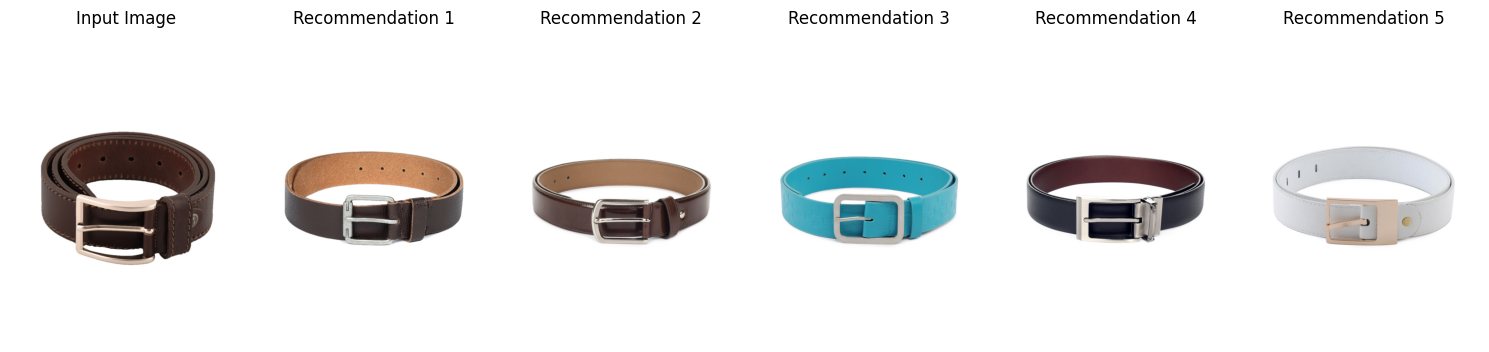

In [57]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/12455.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


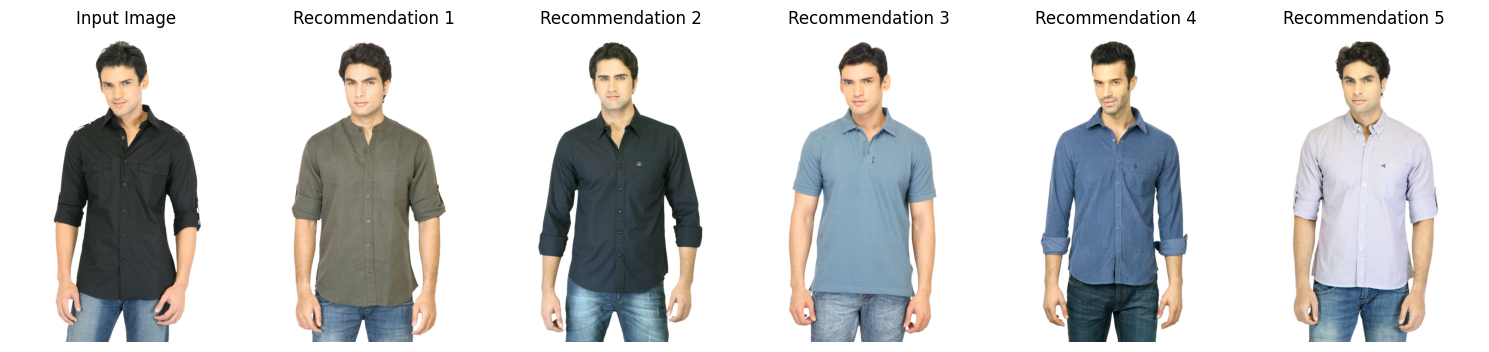

In [58]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/11455.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


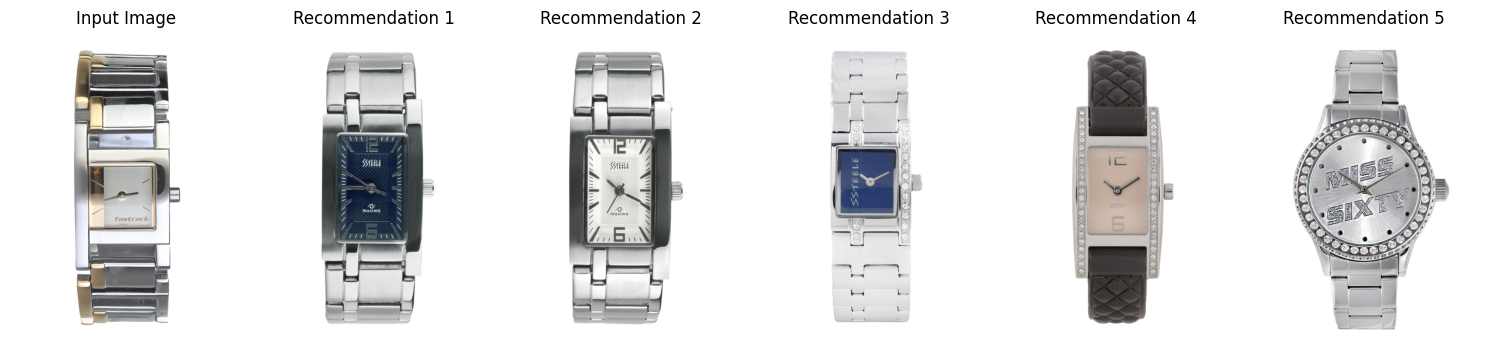

In [59]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10105.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


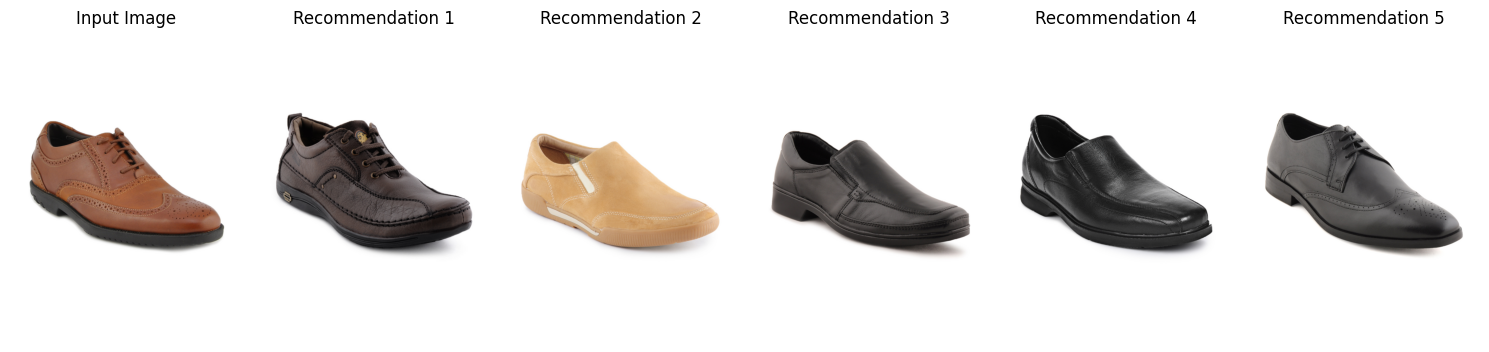

In [60]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10145.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


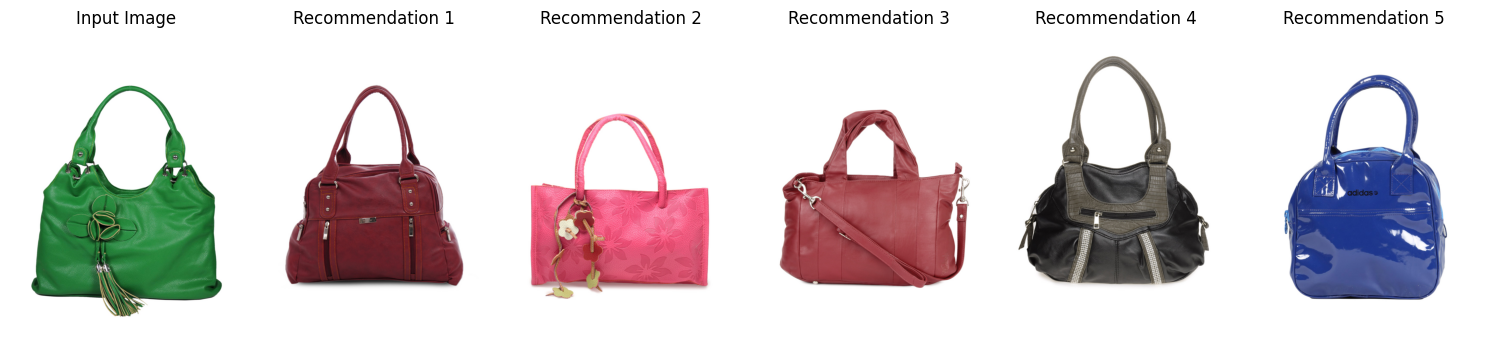

In [61]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10245.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


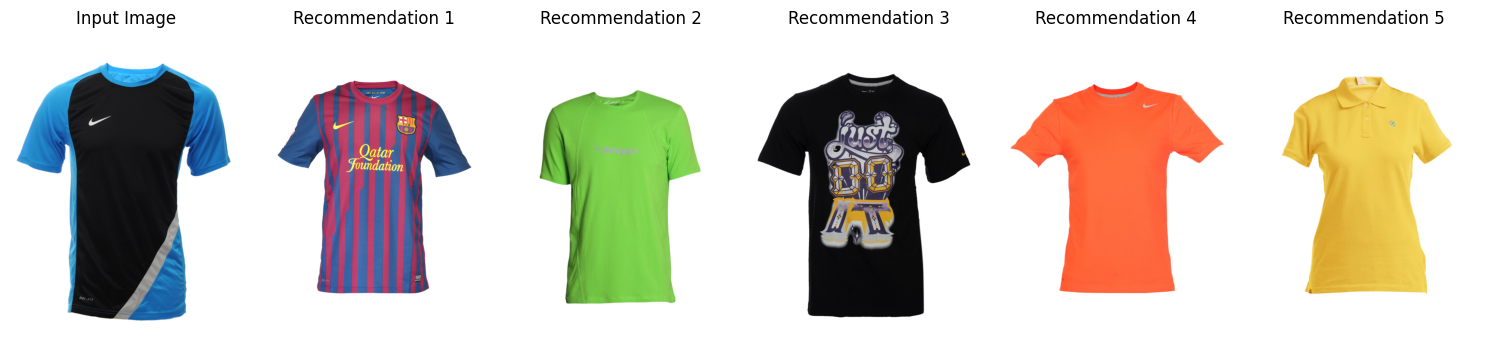

In [62]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10005.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


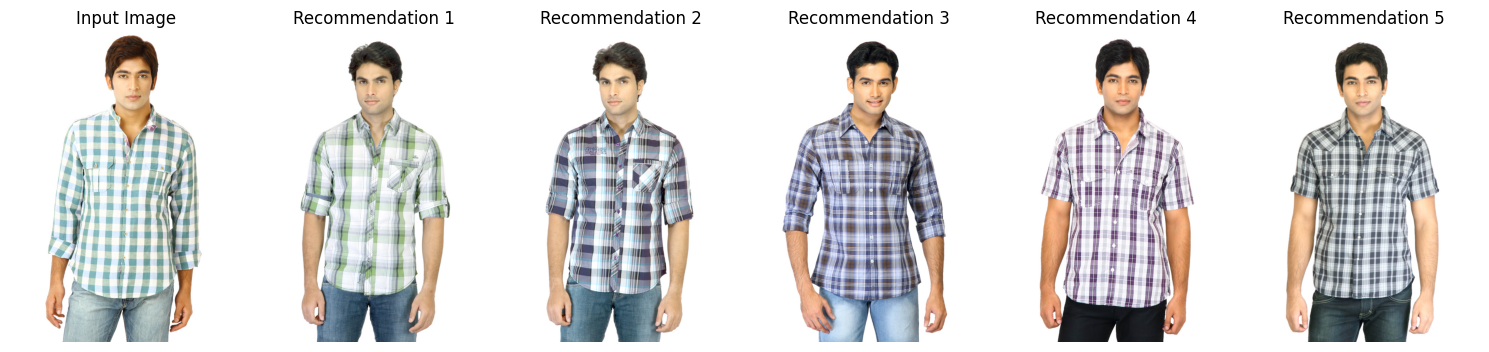

In [63]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10425.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


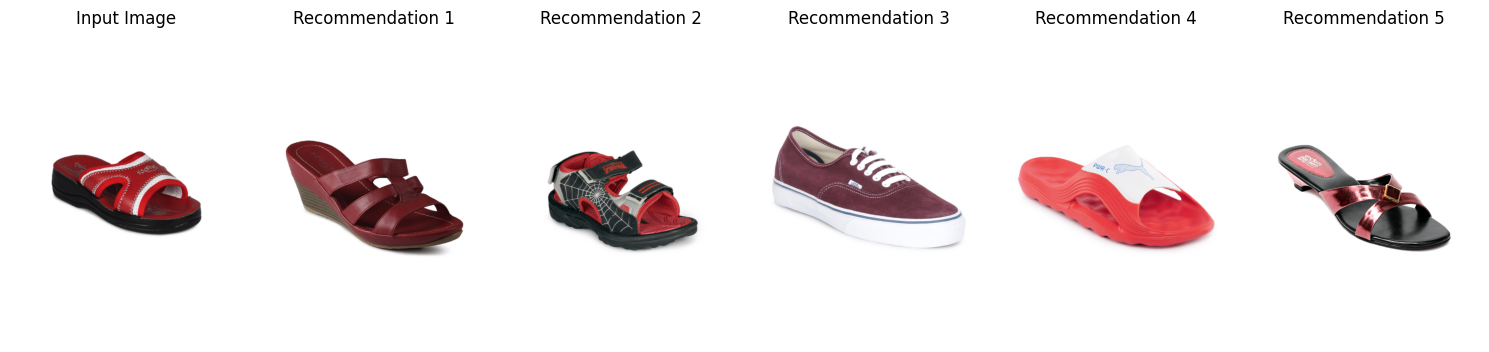

In [64]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/44425.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


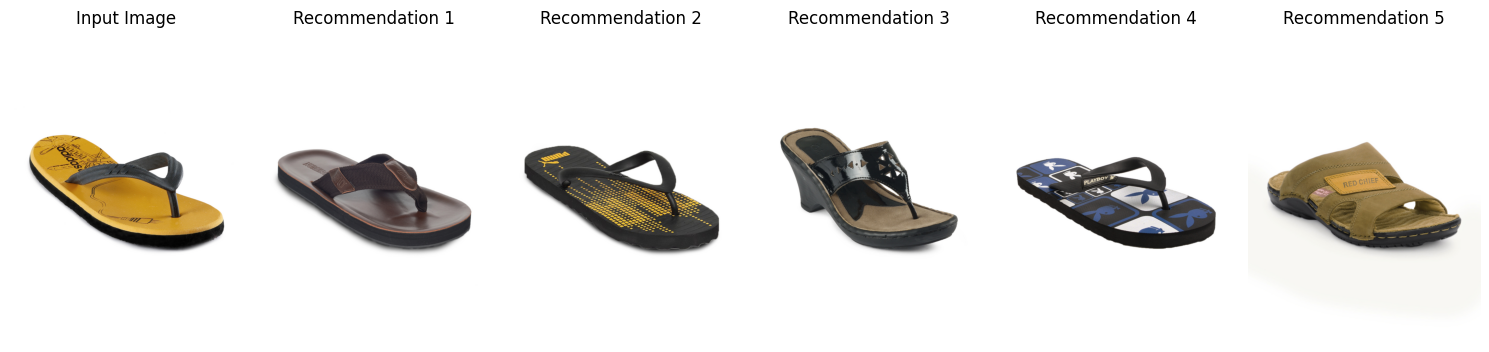

In [65]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/21187.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


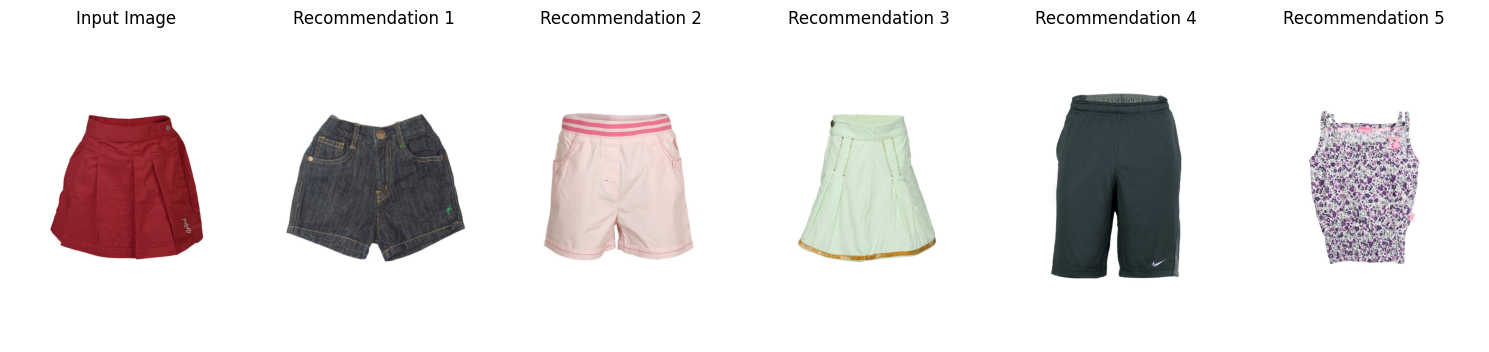

In [66]:
input_image_path = '/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/13305.jpg'
recommend_fashion_item_cnn(input_image_path, all_features, image_paths_list, model)